In [16]:
%load_ext autoreload
%autoreload 2

from constructions import *
from plt_utils import *
from geometricMultiGrid1D import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1.2 1D model problem
## (b)

C:\Users\isido\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


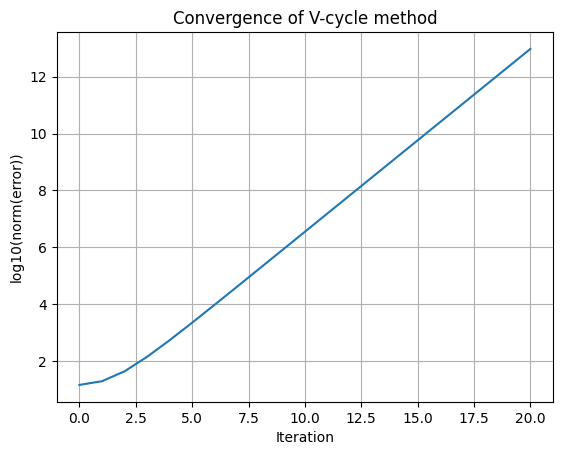

interactive(children=(IntSlider(value=0, description='i', max=20), Output()), _dom_classes=('widget-interact',…

In [4]:
from functools import partial
from scipy.sparse.linalg import spsolve
from scipy.linalg import norm


def helmholtz1D_model(sigma=-600,n=64,recursion_depth=5,iterations =20):
    f = pointsource_half(n)
    u_approx = guessv0(n)
    u_exact = spsolve(helmholtz1D(n,sigma),f)

    errors = [u_exact-u_approx] 
    # Solve using the V-cycle method
    for _ in range(iterations):
        u_approx = geoVcycle1D(
            mat = partial(helmholtz1D,sigma=sigma), 
            f= f, 
            u = u_approx, 
            nu1=1,
            nu2=1,
            relax=partial(wjacobi,omega= 2/3), 
            restrict=simple_restrict, 
            interpolate=simple_interpolate, 
            recursion_depth=recursion_depth)
        errors.append(u_exact-u_approx)
    norms = np.array([norm(e) for e in errors])
    plt.plot(range(len(norms)),np.log10(norms))
    plt.xlabel("Iteration")
    plt.ylabel("log10(norm(error))")
    plt.grid(True)
    plt.title("Convergence of V-cycle method")
    plt.show()
    plt_vecs(errors,[f"errors after {j} vcycles" for j in range(len(errors))]) 

helmholtz1D_model()

# (D)

In [6]:
import ipywidgets as widgets
from IPython.display import display

n_slider = widgets.IntSlider(value=25, min=1, max=50, step=1, description='n')
sigma_slider = widgets.FloatSlider(value=0, min=-10**3, max=10**3, step=10, description='sigma')

def plt_eigen_H(n,sigma):  
    title = rf'Eigenvector $n={n},\sigma = {sigma}$'
    plt_eigen(helmholtz1D(n, sigma),title)

interactive_plot = widgets.interactive(
    plt_eigen_H,
    n=n_slider,
    sigma=sigma_slider
)

display(interactive_plot)


interactive(children=(IntSlider(value=25, description='n', max=50, min=1), FloatSlider(value=0.0, description=…

# 1.3
## (b)

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider

def G(theta,sigma,omega,n):
    return  1-omega+ 2*(omega * n**2)*np.cos(theta)/(2*n**2+sigma)

@interact(
    n=widgets.IntSlider(min=1, max=64, value=32),
    sigma_real=widgets.FloatSlider(min=-600, max=600, step=1, value=0),
    sigma_complex=widgets.FloatSlider(min=-10**3, max=10**3, step=1, value=0),
    omega=widgets.FloatSlider(min=-1, max=1, step=0.1, value=2/3)
)
def update(sigma_real,sigma_complex, omega, n):
    sigma = complex(sigma_real,sigma_complex)
    theta = np.linspace(-np.pi, np.pi, n)
    Gs = G(theta, sigma, omega, n)
    Gs_sorted = np.array(sorted(Gs, key=lambda x: np.abs(
        x)*(0 if x.real == 0 else x.real/np.abs(x.real))))
    plt.clf()
    plt.plot(range(len(Gs)), Gs.real, label=r'$R(G(\theta))$',alpha=0.2)
    plt.plot(range(len(Gs)), Gs.imag, label=r'$im(G(\theta))$',alpha=0.2)
    plt.plot(range(len(Gs)), Gs_sorted.real, label=r'sorted $R(G(\theta))$',linestyle="--")
    plt.plot(range(len(Gs)), Gs_sorted.imag, label=r'sorted $im(G(\theta))$',linestyle="--")
    plt.plot(range(len(Gs)), np.abs(Gs_sorted), label=r'sorted $|G(\theta)|$',linestyle="--")
    plt.grid()
    title = rf'Eigenvector $n={n},\sigma = {sigma}, \omega = {omega}$'
    plt_eigen(Romega(n, sigma,omega),title)



interactive(children=(FloatSlider(value=0.0, description='sigma_real', max=600.0, min=-600.0, step=1.0), Float…

In [18]:
import ipywidgets as widgets
from IPython.display import display

n_slider = widgets.IntSlider(value=25, min=1, max=64, step=1, description='n')
sigma_slider = widgets.FloatSlider(value=0, min=-10**3, max=10**3, step=10, description='sigma')
omega_slider=widgets.FloatSlider(min=-1, max=1, step=0.1, value=2/3, description='omega') 

def plt_eigen_R(n,sigma,omega):  
    title = rf'Eigenvector $n={n},\sigma = {sigma}, \omega = {omega}$'
    plt_eigen(Romega(n, sigma,omega),title)

interactive_plot = widgets.interactive(
    plt_eigen_R,
    n=n_slider,
    sigma=sigma_slider,
    omega=omega_slider
)

display(interactive_plot)

interactive(children=(IntSlider(value=25, description='n', max=64, min=1), FloatSlider(value=0.0, description=…

## (d)

In [44]:
G(0,-600,2/3,64)

1.0526870389884089